In [1]:
import numpy as np
import pandas as pd

# ML libs
import tensorflow as tf
from tensorflow import keras
import sklearn
import xgboost
import scikeras

# optimization
import keras_adabound

# Hypertuning libs
import keras_tuner
import skopt
import hyperopt

import scipy
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split

(X, y), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
y_dim = len(class_names)

# One-Hot encode y
#y = np.array([[(y_i == c) for c in range(y_dim)] for y_i in y])
#y_test = np.array([[(y_i == c) for c in range(y_dim)] for y_i in y_test])

val_proportion = X_test.shape[0] / X.shape[0]
(X_train, X_val, y_train, y_val) = train_test_split(X, y, test_size=val_proportion)

# reformat the data
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0


In [3]:
print(X.shape)
print(y.shape)

print()

print(X_test.shape)
print(y_test.shape)

print()

print(X_train.shape)
print(y_train.shape)

print()

print(X_val.shape)
print(y_val.shape)

(60000, 28, 28)
(60000,)

(10000, 28, 28)
(10000,)

(50000, 28, 28)
(50000,)

(10000, 28, 28)
(10000,)


In [4]:
class_names[y_train[2]]

'Ankle boot'

In [5]:
def visualize(X_):
    plt.imshow(X_, cmap="binary")
    plt.axis("off")
    plt.show()

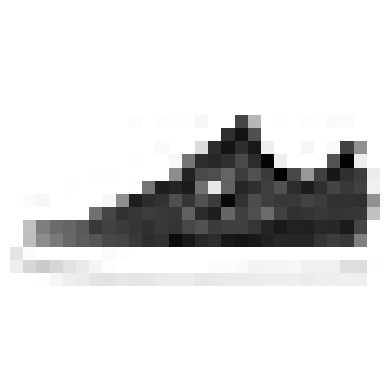

In [6]:
visualize(X_train[2])

In [7]:
X_train_x1D = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2])
X_val_x1D = X_val.reshape(X_val.shape[0], X_val.shape[1]*X_val.shape[2])
X_test_x1D = X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2])

X_train_x1D.shape

(50000, 784)

In [8]:
from xgboost import XGBClassifier

xgb = XGBClassifier(n_estimators=128, learning_rate=0.1, early_stopping_rounds=10)

xgb.fit(X_train_x1D, y_train, eval_set=[(X_val_x1D, y_val)])

[0]	validation_0-mlogloss:1.97619
[1]	validation_0-mlogloss:1.75745
[2]	validation_0-mlogloss:1.58985
[3]	validation_0-mlogloss:1.45482
[4]	validation_0-mlogloss:1.34134
[5]	validation_0-mlogloss:1.24465
[6]	validation_0-mlogloss:1.16064
[7]	validation_0-mlogloss:1.08763
[8]	validation_0-mlogloss:1.02254
[9]	validation_0-mlogloss:0.96402
[10]	validation_0-mlogloss:0.91174
[11]	validation_0-mlogloss:0.86449
[12]	validation_0-mlogloss:0.82168
[13]	validation_0-mlogloss:0.78300
[14]	validation_0-mlogloss:0.74796
[15]	validation_0-mlogloss:0.71600
[16]	validation_0-mlogloss:0.68717
[17]	validation_0-mlogloss:0.66064
[18]	validation_0-mlogloss:0.63627
[19]	validation_0-mlogloss:0.61389
[20]	validation_0-mlogloss:0.59330
[21]	validation_0-mlogloss:0.57442
[22]	validation_0-mlogloss:0.55717
[23]	validation_0-mlogloss:0.54145
[24]	validation_0-mlogloss:0.52679
[25]	validation_0-mlogloss:0.51357
[26]	validation_0-mlogloss:0.50057
[27]	validation_0-mlogloss:0.48892
[28]	validation_0-mlogloss:0.4

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=10, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=128,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [10]:
def plotHistory(hist):
    pd.DataFrame(hist.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1) # vertical range: [0, 1]
    plt.show()

In [8]:
from keras.models import Sequential
from keras import layers
from keras.layers import Dense, BatchNormalization, Dropout, Activation, Input, Flatten
from keras.regularizers import L2
from keras.losses import SparseCategoricalCrossentropy
from keras.callbacks import EarlyStopping
from keras_adabound import AdaBound

history = [None] * 5
models = [None] * 5

class MonteCarloDropout(Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)
        
model_seq1 = Sequential([
    Flatten(input_shape=(X.shape[1], X.shape[2])),
    BatchNormalization(),
    
    Dense(392),
    Activation("swish"),
    Dropout(rate=0.2),
    
    Dense(200, kernel_initializer="glorot_normal"),
    Activation("swish"),
    Dropout(rate=0.2),
    
    Dense(100),
    Activation("swish"),
    
    Dense(50, kernel_initializer="he_uniform"),
    Activation("relu"),
    
    Dense(units=len(class_names)+1, activation="linear")
])

model_seq1.compile(optimizer=AdaBound(learning_rate=0.01, final_lr=0.1), loss=SparseCategoricalCrossentropy(from_logits=True), 
                   metrics=["sparse_categorical_accuracy"])

history[0] = model_seq1.fit(X_train, y_train, batch_size=64, epochs=50, validation_data=(X_val, y_val),
                                     callbacks=[EarlyStopping(patience=10, restore_best_weights=True)])
models.append(model_seq1)

Epoch 1/50
782/782 [==============================] - 5s 5ms/step - loss: 0.6519 - sparse_categorical_accuracy: 0.7674 - val_loss: 0.4362 - val_sparse_categorical_accuracy: 0.8424
Epoch 2/50
782/782 [==============================] - 4s 5ms/step - loss: 0.4872 - sparse_categorical_accuracy: 0.8258 - val_loss: 0.4081 - val_sparse_categorical_accuracy: 0.8507
Epoch 3/50
782/782 [==============================] - 4s 4ms/step - loss: 0.4450 - sparse_categorical_accuracy: 0.8377 - val_loss: 0.3912 - val_sparse_categorical_accuracy: 0.8574
Epoch 4/50
782/782 [==============================] - 4s 5ms/step - loss: 0.4229 - sparse_categorical_accuracy: 0.8458 - val_loss: 0.3746 - val_sparse_categorical_accuracy: 0.8629
Epoch 5/50
782/782 [==============================] - 3s 4ms/step - loss: 0.4061 - sparse_categorical_accuracy: 0.8514 - val_loss: 0.3644 - val_sparse_categorical_accuracy: 0.8643
Epoch 6/50
782/782 [==============================] - 4s 4ms/step - loss: 0.3870 - sparse_categorica

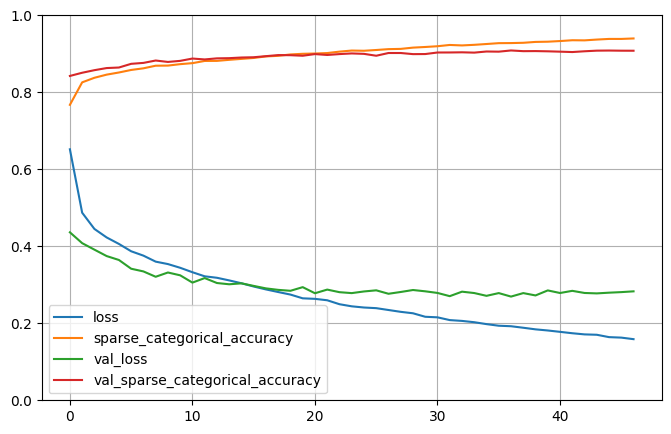

In [11]:
plotHistory(history[0])

In [38]:
from keras.callbacks import LearningRateScheduler

def splitAB(X, axis):
    dim = axis + 1
    boundary = (X.shape[dim] // 2)
    return (X[:, :boundary, :], X[:, boundary:, :])

# split by row
(X_trainA, X_trainB) = splitAB(X_train, 0)
(X_valA, X_valB) = splitAB(X_val, 0) 
(X_testA, X_testB) = splitAB(X_test, 0)

# Model
inputA = Input(shape=X_trainA.shape[1:], name="input 1")
inputB = Input(shape=X_trainB.shape[1:], name="input 2")

flattenA = Flatten(input_shape=X_trainA.shape[1:])(inputA)
flattenB = Flatten(input_shape=X_trainB.shape[1:])(inputB)

batchnormA = BatchNormalization()(flattenA)
batchnormB = BatchNormalization()(flattenB)

hl1_1 = Dense(250, kernel_initializer="he_uniform")(batchnormA)
hl1_1_a = layers.LeakyReLU(alpha=0.15)(hl1_1)
hl1_1_fin = Dropout(rate=0.15)(hl1_1_a)

hl1_2 = Dense(250, kernel_initializer="he_uniform")(batchnormB)
hl1_2_a = layers.LeakyReLU(alpha=0.15)(hl1_2)
hl1_2_fin = Dropout(rate=0.15)(hl1_2_a)

hl2 = Dense(75, kernel_initializer="he_normal", use_bias=False)(layers.concatenate([hl1_1_fin, hl1_2_fin]))
hl2_norm = BatchNormalization()(hl2)
hl2_a = layers.ELU(alpha=1.0)(hl2_norm)
hl2_fin = Dropout(rate=0.0)(hl2_a)

hl3 = Dense(50, kernel_initializer="glorot_uniform", use_bias=False)(layers.concatenate([hl1_1_fin, hl1_2_fin, hl2_fin]))
hl3_norm = BatchNormalization()(hl3)
hl3_a = Activation("swish")(hl3_norm)

L_out = Dense(y_dim+1, kernel_initializer="glorot_uniform", activation="linear")(layers.concatenate([flattenA, flattenB, hl1_1_fin, hl1_2_fin, hl2_fin, hl3_a]))

model_func2 = keras.Model(inputs=(inputA, inputB), outputs=[L_out])

lr = 0.02
decayRate = 1.0
model_func2.compile(loss=SparseCategoricalCrossentropy(from_logits=True), optimizer=AdaBound(learning_rate=lr, final_lr=0.05),
                    metrics=["sparse_categorical_accuracy"])

def learning_rate_decay_schedule(lr0, decayRate):
    def scheduler(epoch, lr):
        return lr * 0.93**decayRate
    
    return scheduler

history[1] = model_func2.fit((X_trainA, X_trainB), y_train, batch_size=256, epochs=150, validation_data=((X_valA, X_valB), y_val),
                               callbacks=[
                                   EarlyStopping(patience=15, restore_best_weights=True)#,
                                   #LearningRateScheduler(learning_rate_decay_schedule(lr, decayRate))
                               ])

models[1] = model_func2

Epoch 1/150
196/196 [==============================] - 3s 7ms/step - loss: 0.8803 - sparse_categorical_accuracy: 0.8014 - val_loss: 0.4476 - val_sparse_categorical_accuracy: 0.8464
Epoch 2/150
196/196 [==============================] - 1s 7ms/step - loss: 0.3975 - sparse_categorical_accuracy: 0.8584 - val_loss: 0.3740 - val_sparse_categorical_accuracy: 0.8683
Epoch 3/150
196/196 [==============================] - 1s 7ms/step - loss: 0.3648 - sparse_categorical_accuracy: 0.8705 - val_loss: 0.3584 - val_sparse_categorical_accuracy: 0.8744
Epoch 4/150
196/196 [==============================] - 1s 7ms/step - loss: 0.3478 - sparse_categorical_accuracy: 0.8741 - val_loss: 0.3445 - val_sparse_categorical_accuracy: 0.8791
Epoch 5/150
196/196 [==============================] - 1s 7ms/step - loss: 0.3416 - sparse_categorical_accuracy: 0.8767 - val_loss: 0.3509 - val_sparse_categorical_accuracy: 0.8756
Epoch 6/150
196/196 [==============================] - 1s 7ms/step - loss: 0.3356 - sparse_cate

196/196 [==============================] - 1s 6ms/step - loss: 0.2505 - sparse_categorical_accuracy: 0.9086 - val_loss: 0.2986 - val_sparse_categorical_accuracy: 0.8957
Epoch 47/150
196/196 [==============================] - 1s 7ms/step - loss: 0.2508 - sparse_categorical_accuracy: 0.9078 - val_loss: 0.2961 - val_sparse_categorical_accuracy: 0.8960
Epoch 48/150
196/196 [==============================] - 1s 7ms/step - loss: 0.2481 - sparse_categorical_accuracy: 0.9094 - val_loss: 0.3075 - val_sparse_categorical_accuracy: 0.8893
Epoch 49/150
196/196 [==============================] - 1s 6ms/step - loss: 0.2467 - sparse_categorical_accuracy: 0.9093 - val_loss: 0.2990 - val_sparse_categorical_accuracy: 0.8939
Epoch 50/150
196/196 [==============================] - 1s 7ms/step - loss: 0.2475 - sparse_categorical_accuracy: 0.9096 - val_loss: 0.2979 - val_sparse_categorical_accuracy: 0.8946
Epoch 51/150
196/196 [==============================] - 1s 7ms/step - loss: 0.2435 - sparse_categorical

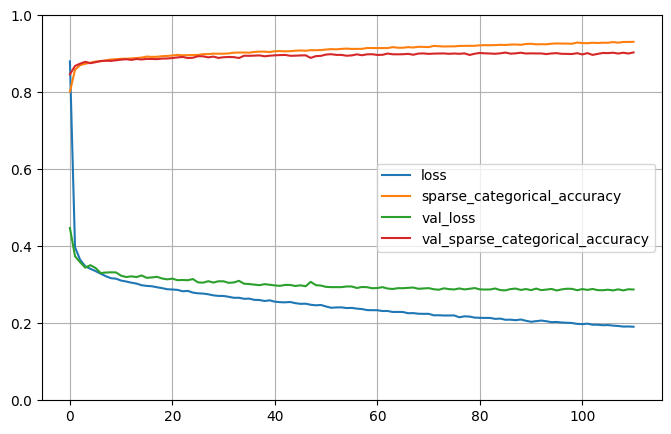

In [39]:
plotHistory(history[1])

In [92]:
model_selu = Sequential([
    Flatten(input_shape=X.shape[1:]),
    BatchNormalization(),
    
    Dense(100, kernel_initializer="lecun_normal"),
    Activation("selu"),
    
    Dense(50, kernel_initializer="lecun_normal"),
    Activation("selu"),
    
    Dense(50, kernel_initializer="lecun_normal"),
    Activation("selu"),
    
    Dense(y_dim+1, kernel_initializer="glorot_uniform"),
    BatchNormalization(),
    Activation('linear')
])

model_selu.compile(loss=SparseCategoricalCrossentropy(from_logits=True), optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001), metrics=["sparse_categorical_accuracy"])

history[2] = model_selu.fit(X_train, y_train, batch_size=128, epochs=50, validation_data=(X_val, y_val),
                            callbacks=[EarlyStopping(patience=10, restore_best_weights=True)])

models[2] = model_selu

Epoch 1/50
391/391 [==============================] - 2s 3ms/step - loss: 0.6743 - sparse_categorical_accuracy: 0.8265 - val_loss: 0.5124 - val_sparse_categorical_accuracy: 0.8589
Epoch 2/50
391/391 [==============================] - 1s 3ms/step - loss: 0.4709 - sparse_categorical_accuracy: 0.8664 - val_loss: 0.4346 - val_sparse_categorical_accuracy: 0.8677
Epoch 3/50
391/391 [==============================] - 1s 3ms/step - loss: 0.3970 - sparse_categorical_accuracy: 0.8785 - val_loss: 0.3654 - val_sparse_categorical_accuracy: 0.8809
Epoch 4/50
391/391 [==============================] - 1s 3ms/step - loss: 0.3490 - sparse_categorical_accuracy: 0.8893 - val_loss: 0.3571 - val_sparse_categorical_accuracy: 0.8806
Epoch 5/50
391/391 [==============================] - 1s 2ms/step - loss: 0.3188 - sparse_categorical_accuracy: 0.8959 - val_loss: 0.3260 - val_sparse_categorical_accuracy: 0.8898
Epoch 6/50
391/391 [==============================] - 1s 2ms/step - loss: 0.2933 - sparse_categorica

In [14]:
plotHistory(history[2])

AttributeError: 'NoneType' object has no attribute 'history'